## Import Necessary Libraries

In [74]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

## Data Directory

In [2]:
train_dir = 'split/train'
train_NORMAL_dir = 'split/train/NORMAL/'
train_PNEUMONIA_dir = 'split/train/PNEUMONIA/'

validation_dir = 'split/validation'
validation_NORMAL_dir = 'split/validation/NORMAL/'
validation_PNEUMONIA_dir = 'split/validation/PNEUMONIA/'

test_dir = 'split/test'
test_NORMAL_dir = 'split/test/NORMAL/'
test_PNEUMONIA_dir = 'split/test/PNEUMONIA/'

## Function for results visualization

In [3]:
def create_charts(cnn, cnn_model):
    
    """
    Define a function for resuts visulaizaiton, which includes:
        1. Train and Validation Loss Plot
        2. Train and Validation Accuracy Plot
        3. Confusion Matrix
        4. ROC Curvs
        5.Statistics:
            1. Accuracy
            2. Precision
            3. Recall
            4. Specificity
            5. F1
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

## Model 5: Convolution Layers = 3, Dense = 64, Epochs = 10, Data Augmentation

In [4]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    """
    
    """
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (64,64),
                                         batch_size = 128,
                                         color_mode = 'grayscale',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [5]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [6]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [7]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 10,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
33/33 [==============================] - 25s 745ms/step - loss: 0.6201 - acc: 0.6800 - val_loss: 0.5333 - val_acc: 0.7295
Epoch 2/10
33/33 [==============================] - 24s 747ms/step - loss: 0.4780 - acc: 0.7644 - val_loss: 0.2911 - val_acc: 0.8780
Epoch 3/10
33/33 [==============================] - 23s 706ms/step - loss: 0.3938 - acc: 0.8081 - val_loss: 0.2997 - val_acc: 0.8951
Epoch 4/10
33/33 [==============================] - 23s 699ms/step - loss: 0.3121 - acc: 0.8784 - val_loss: 0.3531 - val_acc: 0.8439
Epoch 5/10
33/33 [==============================] - 23s 715ms/step - loss: 0.2873 - acc: 0.8818 - val_loss: 0.2817 - val_acc: 0.8985
Epoch 6/10
33/33 [==============================] - 24s 721ms/step - loss: 0.3011 - acc: 0.8698 - val_loss: 0.2276 - val_acc: 0.9096
Epoch 7/10
33/33 [==============================] - 24s 722ms/step - loss: 0.2601 - acc: 0.8908 - val_loss: 0.1999 - val_acc: 0.9334
Epoch 8/10
33/33 [==============================] - 24s 727ms/step - 

## Evaluate the Model Performance

### Train and Validation Loss Plot

**Train and Validation loss**: The loss values are calculated from loss function. The loss function is used to optimize the model performance.The loss is calculated on training and validation and its interpretation is based on how well the model is doing in these two datasets. It is the sum of errors made for each example in training or validation sets. Loss values imply how poorly or well a model behaves after each iteration of optimization.


In [29]:
# Define function for plotting train and validation curve
def train_validation_loss(cnn_model):
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    fig = plt.figure(figsize = (8,5))
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

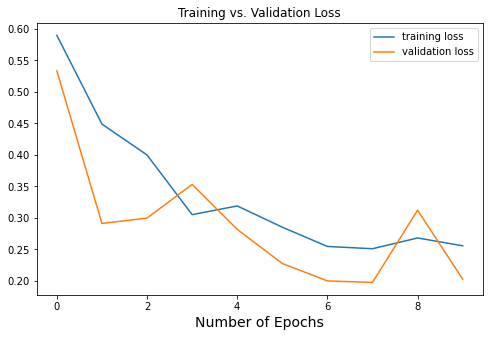

In [30]:
train_validation_loss(cnn_model)

### Train and Validation Accuracy Plot

**Train and Validation Accuracry**: The accuracy of a model is usually determined after the model parameters and is calculated in the form of a percentage. It is the measure of how accurate your model's prediction is compared to the true data. 

In [35]:
# Define function for plotting train and validation curve
def train_validation_acc(cnn_model):
    train_loss = cnn_model.history['acc']
    val_loss = cnn_model.history['val_acc']
    fig = plt.figure(figsize = (8,5))
    plt.title("Training vs. Validation Acc")
    plt.plot(train_loss, label='training acc')
    plt.plot(val_loss, label='validation acc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

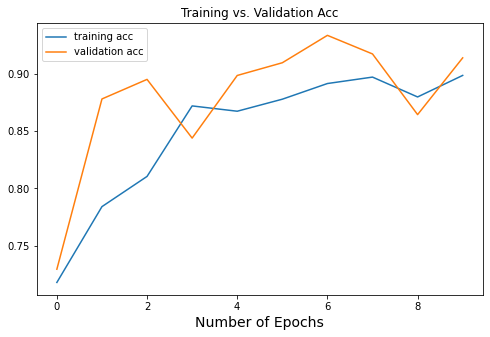

In [36]:
train_validation_acc(cnn_model)

### Confusion Matrix

#### Method_1

In [90]:
from mlxtend.plotting import plot_confusion_matrix

In [126]:
def cm_plot_1(cnn):
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    cm = confusion_matrix(y_true,y_pred)
    plot_confusion_matrix(cm,figsize = (12,8), hide_ticks = True, cmap = plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize = 22) 
    plt.xticks(range(2), ['Normal','Pneumonia'], fontsize = 16)
    plt.yticks(range(2), ['Normal','Pneumonia'], fontsize = 16)
#     plt.xlable("Predicted", size = 12)
#     plt.ylable("Actual", size = 12)
    

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


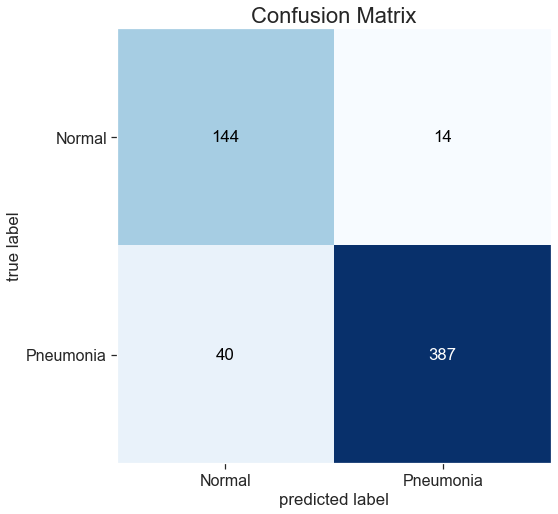

In [127]:
cm_plot_1(cnn)

#### Method_2

In [143]:
def cm_plot_2(cnn):
    fig = plt.figure(figsize=(10, 8))
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    cm = confusion_matrix(y_true,y_pred)
    
    #####################################
    
    # Set up the labels for in the confusion matrix
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']
    #####################################
    
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap=plt.cm.Blues, xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


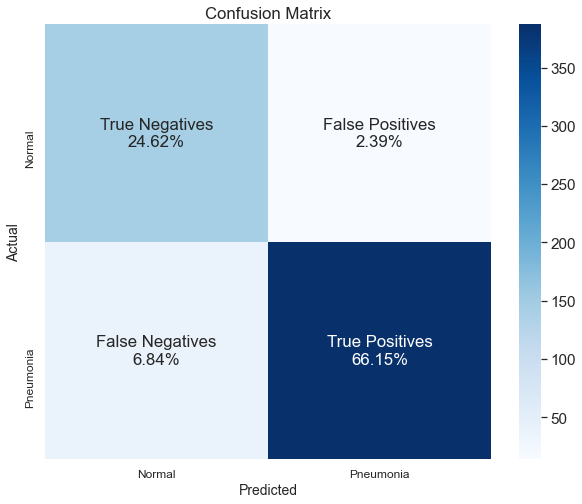

In [144]:
cm_plot_2(cnn)

### ROC Curve and AUC Score

**ROC and AUC**： AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

In [166]:
def ROC_curve_AUC_socre(cnn):
    fig = plt.figure(figsize=(10, 8))
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ################################
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


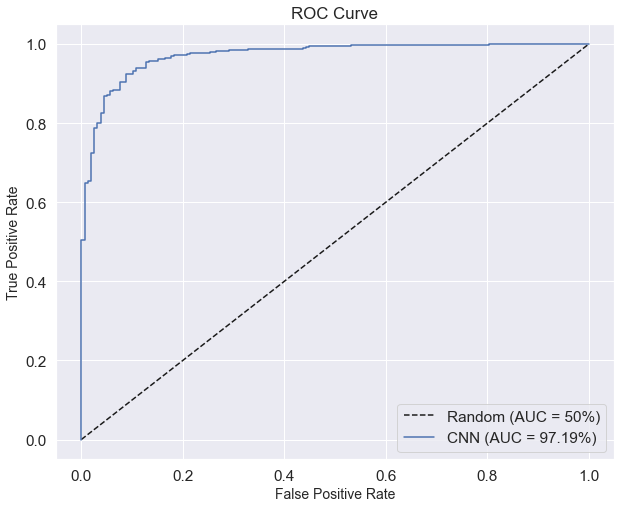

In [167]:
ROC_curve_AUC_socre(cnn)

### Summary Statistics

- **Accuracy = (TP + TN) / (Total Observation)**: Total number of predictions a model gets right

- **Precision = TP / (TP+FP)**: Number of True Positives out of number of Predicted Positives

- **True Positive Rate / Recall / Sensitivity = TP / (TP+FN)**: Number of True Positives out of number of actual total positives

- **Specificity = TN / (TN+FP)**: Number of True Negatives out of number of actual total negatives

- **False Positive Rate = 1 - Specificity = FP / (TN+FP)**: Number of False Positives out of number of actual total negatives
- **F1 socre**: Harmonic Mean of Precision and Recall. When a model's F1 socre is high, you know that your model is doing well.


In [174]:
def Summary_Stats(cnn):
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    #############################
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    #ravel, which is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. 
    #The returned array has the same data type as the source array or input array.
    accuracy = (TP + TN) / np.sum(cm) 
    precision = TP / (TP+FP) 
    recall =  TP / (TP+FN)
    specificity = TN / (TN+FP) 
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    return stats_summary

In [171]:
Summary_Stats(cnn)

'[Summary Statistics]\nAccuracy = 90.77% | Precision = 96.51% | Recall = 90.63% | Specificity = 91.14% | F1 Score = 93.48%'

## Save and Load Model